In [71]:
import numpy as np
import pygmo as pg
import pykep as pk
import matplotlib.pyplot as plt


In [72]:

################
### Constants
################

# Start and end epochs
T_START = pk.epoch_from_iso_string("30190302T000000")
T_END = pk.epoch_from_iso_string("30240302T000000")

# Cavendish constant (m^3/s^2/kg)
G = 6.67430e-11

# Sun_mass (kg)
SM = 1.989e30

# Mass and Mu of the Trappist-1 star
MS = 8.98266512e-2 * SM
MU_TRAPPIST = G * MS

# DV per propellant [m/s]
DV_per_propellant = 10000

# Maximum time to fully mine an asteroid
TIME_TO_MINE_FULLY = 30

# Loading the asteroid data
data = np.loadtxt("candidates.txt")
asteroids = []
for line in data:
    p = pk.planet.keplerian(
        T_START,
        (
            line[1],
            line[2],
            line[3],
            line[4],
            line[5],
            line[6],
        ),
        MU_TRAPPIST,
        G * line[7],  # mass in planet is not used in UDP, instead separate array below
        1,  # these variable are not relevant for this problem
        1.1,  # these variable are not relevant for this problem
        "Asteroid " + str(int(line[0])),
    )
    asteroids.append(p)



# And asteroids' masses and material type
asteroid_masses = data[:, -2]
asteroid_materials = data[:, -1].astype(int)

astID_mat0 = []
astID_mat1 = []
astID_mat2 = []
astID_mat3 = []
astID_All = []

for i in range(0,10000):
    astID_All.append(i)
    if asteroid_materials[i]==0:
        astID_mat0.append(i)
    if asteroid_materials[i]==1:
        astID_mat1.append(i)
    if asteroid_materials[i]==2:
        astID_mat2.append(i)
    if asteroid_materials[i]==3:
        astID_mat3.append(i)

def filtermasse(ll,masse):
    rr = []
    for i in range(0,len(ll)):
        if(asteroid_masses[ll[i]] >= masse):
            rr.append(ll[i])
    return rr 

def llambert(startid,nextAst,timepast,timearr, tof, propellant):
        r1, v1 = asteroids[startid].eph(T_START.mjd2000 + timepast)
        r2, v2 = asteroids[nextAst].eph(T_START.mjd2000 + timearr)
        l = pk.lambert_problem(r1=r1, r2=r2, tof=tof * pk.DAY2SEC, mu=MU_TRAPPIST, cw=False, max_revs=0)
        DV1 = [a - b for a, b in zip(v1, l.get_v1()[0])]
        DV2 = [a - b for a, b in zip(v2, l.get_v2()[0])]
        DV = np.linalg.norm(DV1) + np.linalg.norm(DV2)
        propellant = propellant - DV / DV_per_propellant
        return [propellant,timearr]
    

def llambertNew(startid,nextAst,timepast,timearr, tof, propellant):

        timepast0 = timepast
        pbetter = 0
        timearr1 = timearr
        tof1 = timearr1-timepast0
        for i in range(0,5):
            if tof1 >= 0.5: 
                propellant,t = llambert(startid,nextAst,timepast0,timearr1,tof1,propellant)
                if propellant> pbetter:
                    pbetter = propellant
                    tof1 = (timearr1-timepast0)*0.99
                    timearr1 = tof1+timepast0
            
            #print("timearr = " , timearr1)
            #print("timepast",timepast0)
            #print("tof=", tof1)
        return [pbetter,timearr1]   
    

In [73]:
class udp:

    def __init__(self,tmining,tarrived1,tarrived2,fuel,startid,nextid):
        self.fuel = fuel
        self.tmining = tmining
        self.tarrived1 = tarrived1
        self.tarrived2 = tarrived2
        self.startid = startid
        self.nextid = nextid
    def fitness(self, x):
        
        timepast = self.tarrived1+self.tmining
        timeofflight = x[0]-timepast
        if timeofflight <= 0.5:
            return [99]
        prop = llambert(self.startid,self.nextid,timepast,x[0],timeofflight,self.fuel)
        if prop <= 0:
            prop = 99*-1
            
        return [prop*-1]

    def get_bounds(self):
        
        xlow=[self.tarrived1+self.tmining+1]
        xupp = [self.tarrived2]
        
        return (xlow,xupp)

    def get_nic(self):
        return 0
    def get_nec(self):
        return 0
    
    def gradient(self, x):
        return pg.estimate_gradient(lambda x: self.fitness(x), x)

In [74]:
def filterM(ll,masse):
        rr = []
        for i in range(0,len(ll)):
            if(asteroid_masses[ll[i]] >= masse):
                rr.append(ll[i])
        return rr

class astroProblem():
    def __init__(self,sid,m0,m1,m2,m3,tof0,tof1,tof2,obj):
        self.obj = obj
        self.m0 = m0
        self.m1 = m1
        self.m2 = m2
        self.m3 = m3
        self.tof0 = tof0
        self.tof1 = tof1
        self.tof2 = tof2
        self.sid = sid
        self.ast_l = asteroids
        self.ast_m = asteroid_masses
        self.ast_types = asteroid_materials
        self.mat_l =[0,0,0,1.0]
        self.MU = MU_TRAPPIST
        self.ast_v = list()
        self.ast_v.append(sid)
        self.ta_l = [0]*100 
        self.tm_l = [0]*100
        self.ast0 = filterM(astID_mat0,m0)
        self.ast1 = filterM(astID_mat1,m1)
        self.ast2 = filterM(astID_mat2,m2)
        self.ast3 = filterM(astID_mat3,m3)
        self.astID_All = self.ast0+self.ast1+self.ast2
        
        
    def calcRoute(self,astvisited,astlistID,tmining, timepast, timearr,tof,fuel):
        pList = []
        astNextList = []
        tlist = []
        masslist = []
        for i in range(0,len(astlistID)):
            if not astlistID[i] in astvisited :
                propellant,tt = llambert(astvisited[-1],astlistID[i],timepast,timearr,tof,fuel)
                if(propellant > 0):
                            pList.append(propellant)
                            astNextList.append(astlistID[i])
                            #tlist.append(tt)
                            masslist.append(asteroid_masses[astlistID[i]])
        if(len(pList) > 0):
            #newlist = list(np.add(np.multiply(pList,[30]*len(pList)),tlist))
            zipped = zip(pList,astNextList,masslist)
            sortt = sorted(zipped,key= lambda x: x[0])
            sortt = list(zip(*sortt))
            pList = list(sortt[0])
            astNextList = list(sortt[1])
            #tlist = list(sortt[2])
        return [pList,astNextList,tlist]
    
    def calculateRouteBestFuel(self,astvisited,astlistID,tmining, timepast, timearr,tof,fuel):
        pList = []
        astNextList = []
        tlist = []
        
        for i in range(0,len(astlistID)):
            if not astlistID[i] in astvisited :
                propellant,tt = llambert(astvisited[-1],astlistID[i],timepast,timearr,tof,fuel)
                if(propellant > 0 and propellant+self.ast_m[i] > fuel):
                            pList.append(propellant)
                            astNextList.append(astlistID[i])
                            #tlist.append(tt)
                            
        if(len(pList) > 0):
           # newlist = list(np.add(np.multiply(pList,[100]*len(pList)),tlist))
            zipped = zip(pList,astNextList)
            sortt = sorted(zipped,key= lambda x: x[0])
            sortt = list(zip(*sortt))
            pList = list(sortt[0])
            astNextList = list(sortt[1])
            #tlist = list(sortt[2])
        return [pList,astNextList,tlist]
    
    def calculateRouteBestPG(self,astvisited,astlistID,timemining, timepast, timearr,tof,fuel):
        pList = []
        astNextList = []
        astarrlist = []
        for i in range(0,len(astlistID)):
            if not astlistID[i] in astvisited :
                #propellant = llambert(astvisited[-1],astlistID[i],timepast,timearr,tof,fuel)
                
                algo = pg.algorithm(uda = pg.mbh(pg.nlopt("slsqp"), stop = 10, perturb = .002))
                algo.set_verbosity(1) # in this case this correspond to logs each 1 call to slsqp
                prob = pg.problem(udp(timemining,timepast-timemining,timearr,
                                        self.mat_l[3],self.ast_v[-1],astlistID[i]))
                pop = pg.population(prob , size = 10)
                pop = algo.evolve(pop)
                
                timearr = pop.champion_x[0]
                propellant= pop.champion_f[0]*-1
                
                if(propellant > 0):
                            pList.append(propellant)
                            astNextList.append(astlistID[i])
                            astarrlist.append(timearr)
        if(len(pList) > 0):
            zipped = zip(pList,astNextList,astarrlist)
            sortt = sorted(zipped,key= lambda x: x[0])
            sortt = list(zip(*sortt))
            pList = list(sortt[0])
            astNextList = list(sortt[1])
            timearr = list(sortt[2])
        return [pList,astNextList,timearr]
    
    
    
       
    
    
    
    def fitness(self):
        ffmasse = 0.75
        ffuel = 0.4
        lfuel = filtermasse(astID_mat3,0.3)
        ll0 = filtermasse(astID_mat0,ffmasse)
        ll2 = filtermasse(astID_mat2,ffmasse)
        llall = ll0+ll2
        ll1 = filtermasse(astID_mat1,0.2)
        for i in range(1,len(self.ta_l)):
            pList=[]
            astNextList=[]
            timepast = self.ta_l[i-1]+self.tm_l[i-1]
            self.ta_l[i]= timepast+19
            tof = self.ta_l[i]-timepast
            
            
            v = True
            w = False
            if(v and self.mat_l[3]<= ffuel):
                pList, astNextList,tlist= self.calculateRouteBestFuel(self.ast_v,lfuel,self.tm_l[i-1],
                                                                    timepast,self.ta_l[i],tof,self.mat_l[3])
                v= False
            if((w and self.mat_l[1] <= 7.5 and self.mat_l[3]> ffuel) or (v  and self.mat_l[1] ==np.min(self.mat_l[:3])) ):
                pList, astNextList,tlist = self.calcRoute(self.ast_v,ll1,self.tm_l[i-1],
                                                                   timepast,self.ta_l[i],tof,self.mat_l[3])
                v = False
            if((w and self.mat_l[1] > 7.5 and self.mat_l[3]> ffuel) or (v  and self.mat_l[0] ==np.min(self.mat_l[:3])) ):
                pList, astNextList,tlist = self.calcRoute(self.ast_v,ll0,self.tm_l[i-1],
                                                                     timepast,self.ta_l[i],tof,self.mat_l[3])
                v = False
            if(not w or (v  and self.mat_l[2] ==np.min(self.mat_l[:3])) and self.mat_l[3]> ffuel):
                pList, astNextList,tlist = self.calcRoute(self.ast_v,ll2,self.tm_l[i-1],
                                                                   timepast,self.ta_l[i],tof,self.mat_l[3])
                
                v = False
            if(False  and self.matList[1] ==np.min(self.matList[:3]) and self.matList[0]<= self.matList[2]):
                pList, astNextList,tlist = self.calcRoute(self.ast_v,ll0,self.tm_l[i-1],
                                                             timepast,self.ta_l[i],tof,self.mat_l[3])
                v = False
            if(False and self.matList[3]> ffuel and self.matList[0]>7 and self.matList[2]< self.matList[0]):
                pList, astNextList,tlist = self.calcRoute(self.ast_v,ll2,self.tm_l[i-1],
                                                             timepast,self.ta_l[i],tof,self.mat_l[3])
                v = False    
                
            if v or len(pList)==0 :
                pList, astNextList,tlist = self.calcRoute(self.ast_v,astID_All,self.tm_l[i-1],
                                                             timepast,self.ta_l[i],tof,self.mat_l[3])
                #print("NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN\n")
                
            
            if(len(pList)==0):
                    print("Ende der Reise") 
                    break
            pp = pList.pop()
            aa = astNextList.pop()
            #tt = tlist.pop()
            
            #self.timearrived[i]=tt
            self.ast_v.append(aa)
            self.mat_l[3] = pp
            
           
            
            if self.asteroid_materials_types[aa] == 3:
                    self.tm_l[i]=self.ast_m[aa]*TIME_TO_MINE_FULLY
                    self.mat_l[3] +=  np.minimum(self.tm_l[i]/TIME_TO_MINE_FULLY,self.ast_m[aa])
                    if self.mat_l[3] >= 1: self.mat_l[3] = 1

            if(self.asteroid_materials_types[aa] == 1): #and np.min(self.matList)+1 >= self.matList[1] ):#########################geänert
                            
                            self.tm_l[i]=self.ast_m[aa]*TIME_TO_MINE_FULLY
                            self.mat_l[1]+= np.minimum(self.tm_l[i]/TIME_TO_MINE_FULLY,self.ast_m[aa])
                                   
            if(self.asteroid_materials_types[aa] == 0):
                            
                            self.tm_l[i]=self.ast_m[aa]*TIME_TO_MINE_FULLY
                            self.mat_l[0]+= np.minimum(self.tm_l[i]/TIME_TO_MINE_FULLY,self.ast_m[aa])
                            
                            
            if(self.asteroid_materials_types[aa] == 2):
                            
                            self.tm_l[i]=self.ast_m[aa]*TIME_TO_MINE_FULLY
                            self.mat_l[2]+= np.minimum(self.tm_l[i]/TIME_TO_MINE_FULLY,self.ast_m[aa])
            if self.mat_l[2] > 7.5:
                    w = True
            
            if len(self.ta_l)-1==i:
                self.ta_l.append(20+timepast)                             
            self.fuellist.append(self.mat_l[3])
            print("fuel = ",self.mat_l[3],"|| Asteroid = ",aa, "|| Material = ",self.mat_l[:3])     
            
            
        n = len(self.ast_v)
        self.fuellist = self.fuellist[:n]
        x = self.ta_l[:n]+self.tm_l[:n]+ self.ast_v 
        y = x+self.fuellist
        return [self.ast_v,self.mat_l[:3],x,y]
            
    def DeepSearch3(self):
        for i in range(1,len(self.ta_l)):
            pList=[]
            astNextList=[]
            timepast = self.ta_l[i-1]+self.tm_l[i-1]
            fmin = 0.45
            
            if(self.mat_l[0] > self.obj and self.mat_l[2]> self.obj):
                self.ta_l[i]= timepast +self.tof1
            if(self.mat_l[2] <= self.obj ):    
                self.ta_l[i]= timepast +self.tof2
            if(self.mat_l[0] <= self.obj and self.mat_l[2] > self.obj ):    
                self.ta_l[i]= timepast +self.tof0
            
            tof = self.ta_l[i]-timepast
            
                
            
            
            
            if(self.mat_l[3]<= fmin):
                pList, astNextList,tlist= self.calcRoute(self.ast_v,self.ast3,self.tm_l[i-1],
                                                                    timepast,self.ta_l[i],tof,self.mat_l[3])
                
            if(len(pList)==0 and self.mat_l[2] <= self.obj and self.mat_l[3]> fmin):
                pList, astNextList,tlist = self.calcRoute(self.ast_v,self.ast2,self.tm_l[i-1],
                                                                   timepast,self.ta_l[i],tof,self.mat_l[3])
                
            if(len(pList)==0 and self.mat_l[2] > self.obj and self.mat_l[0] < self.obj  and self.mat_l[3]> fmin):
                pList, astNextList,tlist = self.calcRoute(self.ast_v,self.ast0,self.tm_l[i-1],
                                                                   timepast,self.ta_l[i],tof,self.mat_l[3])
                 
            if(len(pList)==0 and self.mat_l[0] > self.obj and self.mat_l[3]> fmin):
                pList, astNextList,tlist = self.calcRoute(self.ast_v,self.ast1,self.tm_l[i-1],
                                                                   timepast,self.ta_l[i],tof,self.mat_l[3])
                
            if len(pList)==0 :
                pList, astNextList,tlist = self.calcRoute(self.ast_v,self.ast0+self.ast1+self.ast2+self.ast3,self.tm_l[i-1],
                                                             timepast,self.ta_l[i],tof,self.mat_l[3])
                
            while len(pList)==0 and self.mat_l[0]>self.obj and self.mat_l[2] > self.obj and self.ta_l[i]+self.tm_l[i] <= 1827:
                pList, astNextList,tlist = self.calcRoute(self.ast_v,self.ast1,self.tm_l[i-1],
                                                             timepast,self.ta_l[i],tof,self.mat_l[3])
                self.ta_l[i]= self.ta_l[i]+0.5
                timepast = self.ta_l[i-1]+self.tm_l[i-1]
                tof = self.ta_l[i]-timepast
                print("while = ",self.ta_l[i])    
            
            if(len(pList)==0):
                    #print("Ende der Reise") 
                    break
            pp = pList.pop()
            aa = astNextList.pop()
           # tt = tlist.pop()
            
           # self.timearrived[i]=tt
            self.ast_v.append(aa)
            self.mat_l[3] = pp
            
           
            
            if self.ast_types[aa] == 3:
                    self.tm_l[i]=self.ast_m[aa]*TIME_TO_MINE_FULLY
                    self.mat_l[3] +=  self.ast_m[aa]
                    if self.mat_l[3] >= 1: self.mat_l[3] = 1

            if(self.ast_types[aa] == 1): 
                            self.tm_l[i]=self.ast_m[aa]*TIME_TO_MINE_FULLY
                            self.mat_l[1]+= self.ast_m[aa]
                                   
            if(self.ast_types[aa] == 0):
                            self.tm_l[i]=self.ast_m[aa]*TIME_TO_MINE_FULLY
                            self.mat_l[0]+= self.ast_m[aa]
                            
            if(self.ast_types[aa] == 2):
                            self.tm_l[i]=self.ast_m[aa]*TIME_TO_MINE_FULLY
                            self.mat_l[2]+= self.ast_m[aa]
            
            
            
            if(self.ta_l[i]+self.tm_l[i] >= 1827):break     
            
            
        n = len(self.ast_v)
        #self.fuellist = self.fuellist[:n]
        x = self.ta_l[:n]+self.tm_l[:n]+ self.ast_v 
        #y = x+self.fuellist
        return [self.ast_v,self.mat_l[:3],x] 
    
    def DeepSearch1(self):
        
        for i in range(1,len(self.ta_l)):
            pList=[]
            astNextList=[]
            timepast = self.ta_l[i-1]+self.tm_l[i-1]
            fmin = 0.5
            
            
            if(self.mat_l[1] <= self.obj ):
                self.ta_l[i]= timepast +self.tof1
            if(self.mat_l[1] > self.obj):
                self.ta_l[i]= timepast +self.tof0
            if(self.mat_l[1] > self.obj and self.mat_l[0] > self.obj):
                self.ta_l[i]= timepast +self.tof2
            
            tof = self.ta_l[i]-timepast
            
            
            if(self.mat_l[3]< fmin):
                pList, astNextList,tlist= self.calcRoute(self.ast_v,self.ast3,self.tm_l[i-1],
                                                                    timepast,self.ta_l[i],tof,self.mat_l[3])
                    
            if(len(pList)==0 and self.mat_l[1] <= self.obj and self.mat_l[3]>= fmin):
                pList, astNextList,tlist = self.calcRoute(self.ast_v,self.ast1,self.tm_l[i-1],
                                                                   timepast,self.ta_l[i],tof,self.mat_l[3])
                 
            if(len(pList)==0 and self.mat_l[1] > self.obj and self.mat_l[0] <= self.obj  and self.mat_l[3]>= fmin):
                pList, astNextList,tlist = self.calcRoute(self.ast_v,self.ast0,self.tm_l[i-1],
                                                                   timepast,self.ta_l[i],tof,self.mat_l[3])
             
            if(len(pList)==0 and self.mat_l[1] >= self.obj and self.mat_l[0] > self.obj and self.mat_l[3]>= fmin):
                pList, astNextList,tlist = self.calcRoute(self.ast_v,self.ast2,self.tm_l[i-1],
                                                                   timepast,self.ta_l[i],tof,self.mat_l[3])
                
            if(len(pList)==0):  
                pList, astNextList,tlist = self.calcRoute(self.ast_v,self.ast0+self.ast1+self.ast2+self.ast3,self.tm_l[i-1],
                                                             timepast,self.ta_l[i],tof,self.mat_l[3])
                    
            while False and len(pList)==0 and np.min(self.mat_l[:3]) > 3 and self.timearrived[i] <= 1800:
                pList, astNextList,tlist = self.calcRoute(self.ast_v,astID_All,self.tm_l[i-1],
                                                             timepast,self.ta_l[i],tof,self.mat_l[3])
                self.ta_l[i]= self.ta_l[i]+0.5
                
            
            if(len(pList)==0 ):
                   # print("Ende der Reise") 
                    break
            pp = pList.pop()
            aa = astNextList.pop()
            #tt = tlist.pop()
            #self.timearrived[i]=tt
            self.ast_v.append(aa)
            self.mat_l[3] = pp
            
            if self.ast_types[aa] == 3:
                    self.tm_l[i]=self.ast_m[aa]*TIME_TO_MINE_FULLY
                    self.mat_l[3] +=  np.minimum(self.tm_l[i]/TIME_TO_MINE_FULLY,self.ast_m[aa])
                    if self.mat_l[3] >= 1: self.mat_l[3] = 1

            if(self.ast_types[aa] == 1): 
                            self.tm_l[i]=self.ast_m[aa]*TIME_TO_MINE_FULLY
                            self.mat_l[1]+= np.minimum(self.tm_l[i]/TIME_TO_MINE_FULLY,self.ast_m[aa])
                                   
            if(self.ast_types[aa] == 0):
                            self.tm_l[i]=self.ast_m[aa]*TIME_TO_MINE_FULLY
                            self.mat_l[0]+= np.minimum(self.tm_l[i]/TIME_TO_MINE_FULLY,self.ast_m[aa])
                            
            if(self.ast_types[aa] == 2):
                            self.tm_l[i]=self.ast_m[aa]*TIME_TO_MINE_FULLY
                            self.mat_l[2]+= np.minimum(self.tm_l[i]/TIME_TO_MINE_FULLY,self.ast_m[aa])
            
            
                                   
            #self.fuellist.append(self.mat_l[3])
            # print("fuel = ",self.matList[3],"|| Asteroid = ",aa, "|| Material = ",self.matList[:3])
            if(self.ta_l[i]+self.tm_l[i] >= 1827):break     
            
            
        n = len(self.ast_v)
        #self.fuellist = self.fuellist[:n]
        x = self.ta_l[:n]+self.tm_l[:n]+ self.ast_v 
        #y = x+self.fuellist
        return [self.ast_v,self.mat_l[:3],x]        
            
    
    
    
    
    
             
            
            
            
            
            
            
            
            
               

In [75]:
minNorm = 0
matl = []
asst = []
x = []
for i in range(0,10000,1):
        #rr = np.random.randint(0,10000)
        prob = astroProblem(i,0.9,0.6,0.9,0.4,17.5,10,17.5,9)
        nn,mm,zz = prob.DeepSearch3()
        if minNorm <=np.min(mm):
            minNorm = np.min(mm)
            matl = mm
            asst = nn
            x = zz
        print("Schleife i = ",i,"|| tof = ",10,"\n mat = ",mm,"||",matl)

Schleife i =  0 || tof =  10 
 mat =  [0, 0, 1.8886158303124305] || [0, 0, 1.8886158303124305]
while =  1314.769044133277
while =  1315.269044133277
while =  1315.769044133277
while =  1316.269044133277
while =  1316.769044133277
while =  1317.269044133277
while =  1317.769044133277
while =  1318.269044133277
while =  1318.769044133277
while =  1319.269044133277
while =  1319.769044133277
while =  1320.269044133277
while =  1320.769044133277
while =  1321.269044133277
while =  1321.769044133277
while =  1322.269044133277
while =  1322.769044133277
while =  1323.269044133277
while =  1323.769044133277
while =  1324.269044133277
while =  1324.769044133277
while =  1325.269044133277
while =  1325.769044133277
while =  1326.269044133277
while =  1326.769044133277
while =  1327.269044133277
while =  1327.769044133277
while =  1328.269044133277
while =  1328.769044133277
while =  1329.269044133277
while =  1329.769044133277
while =  1330.269044133277
while =  1330.769044133277
while =  1331.

In [76]:
minNorm = 0
matl = []
asst = []
x = []  
y = []
#832.348410730199

J = []
D = []
a = []
b = []
c = []
u = 20

while u <= 20.5:
    minNorm = 0
    matl = []
    asst = []
    x = []
    for i in range(0,10000,1):
        #rr = np.random.randint(0,10000)
        prob = astroProblem(i,0.9,0.6,0.9,0.4,17.5,10,17.5,9)
        nn,mm,zz = prob.DeepSearch1()
        if minNorm <=np.min(mm):
            minNorm = np.min(mm)
            matl = mm
            asst = nn
            x = zz
        print("Schleife i = ",i,"|| tof = ",u,"\n mat = ",mm,"||",matl)
        
    #print(x)        
    #print(asst)
    #print(matl)
    a.append(matl[0])
    b.append(matl[1])
    c.append(matl[2])
    D.append(u)
    u += 0.5


Schleife i =  0 || tof =  20 
 mat =  [0, 0.6641377081904295, 0] || [0, 0.6641377081904295, 0]
Schleife i =  1 || tof =  20 
 mat =  [0, 0.7359899840891149, 0] || [0, 0.7359899840891149, 0]
Schleife i =  2 || tof =  20 
 mat =  [0, 1.6643130001980984, 0] || [0, 1.6643130001980984, 0]
Schleife i =  3 || tof =  20 
 mat =  [0, 0, 1.832966423624094] || [0, 0, 1.832966423624094]
Schleife i =  4 || tof =  20 
 mat =  [0, 1.4992664616088398, 0] || [0, 1.4992664616088398, 0]
Schleife i =  5 || tof =  20 
 mat =  [0, 0.7359899840891149, 0.975440612672195] || [0, 0.7359899840891149, 0.975440612672195]
Schleife i =  6 || tof =  20 
 mat =  [0, 0, 0.9158600734088462] || [0, 0, 0.9158600734088462]
Schleife i =  7 || tof =  20 
 mat =  [0, 1.4992664616088398, 0] || [0, 1.4992664616088398, 0]
Schleife i =  8 || tof =  20 
 mat =  [0, 0, 0.9119002156918283] || [0, 0, 0.9119002156918283]
Schleife i =  9 || tof =  20 
 mat =  [0, 0, 1.887470471931274] || [0, 0, 1.887470471931274]
Schleife i =  10 || to

KeyboardInterrupt: 

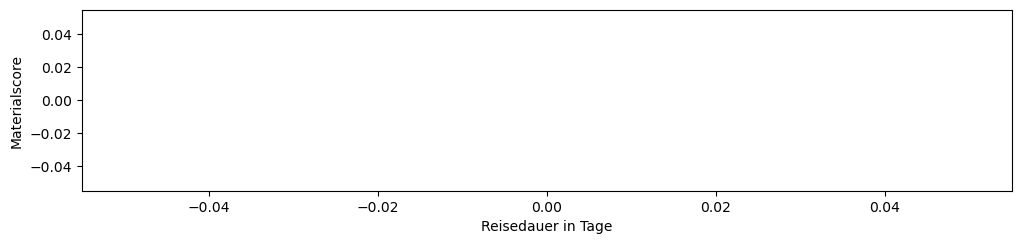

In [ ]:
J = [a,b,c]
plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.plot(D,J[0],"red")
plt.subplot(3,1,1)
plt.plot(D,J[1],"green")
plt.subplot(3,1,1)
plt.plot(D,J[2],"blue")

plt.xlabel("Reisedauer in Tage")
plt.ylabel("Materialscore")
plt.show()
for i in range(0,len(J[0]),1):
 print("i = ",i, "||", J[0][i],J[1][i],J[2][i])

In [ ]:
matl=[0,0,0]
x = []
asst = []
minNorm  =0
for i in range(1,10000,1):
        u = 10
        rr = np.random.randint(0,10000)
        prob = astroProblem(i,0.9,0.6,0.9,0.4,17.5,10,17.5,9)
        nn,mm,zz = prob.DeepSearch3()
        if minNorm <=np.min(mm):
            minNorm = np.min(mm)
            matl = mm
            asst = nn
            x = zz
            
            while(mm[0] >9 and u <= 27):
                    prob = astroProblem(i,0.9,0.6,0.9,0.4,17.5,u,17.5,9)
                    nn,mm,zz = prob.DeepSearch3()
                    if minNorm <=np.min(mm):
                        minNorm = np.min(mm)
                        matl = mm
                        asst = nn
                        x = zz
                    print("Schleife i = ",i,"|| tof = ",u,"\n mat = ",mm,"||",matl)    
                    u +=0.25
        print("Schleife i = ",i,"|| tof = ",u,"\n mat = ",mm,"||",matl)

Schleife i =  1 || tof =  10 
 mat =  [9.562087616954244, 0, 9.466158628429946] || [9.562087616954244, 0, 9.466158628429946]
Schleife i =  1 || tof =  10.25 
 mat =  [9.562087616954244, 0, 9.466158628429946] || [9.562087616954244, 0, 9.466158628429946]
Schleife i =  1 || tof =  10.5 
 mat =  [9.562087616954244, 0, 9.466158628429946] || [9.562087616954244, 0, 9.466158628429946]
Schleife i =  1 || tof =  10.75 
 mat =  [9.562087616954244, 0, 9.466158628429946] || [9.562087616954244, 0, 9.466158628429946]
Schleife i =  1 || tof =  11.0 
 mat =  [9.562087616954244, 0, 9.466158628429946] || [9.562087616954244, 0, 9.466158628429946]
Schleife i =  1 || tof =  11.25 
 mat =  [9.562087616954244, 0, 9.466158628429946] || [9.562087616954244, 0, 9.466158628429946]
Schleife i =  1 || tof =  11.5 
 mat =  [9.562087616954244, 0, 9.466158628429946] || [9.562087616954244, 0, 9.466158628429946]
Schleife i =  1 || tof =  11.75 
 mat =  [9.562087616954244, 0, 9.466158628429946] || [9.562087616954244, 0, 9

In [ ]:
print("länge vektor: ",len(asst))
print(x)
from esa_evaluation import udp
udp.fitness(x,True)

länge vektor:  44
[0, 17.5, 62.29001076087722, 108.60172187671125, 154.91065262530827, 200.5848663247838, 243.64566261972618, 289.47269957095943, 336.22673544515806, 373.1435774884586, 417.91450808325067, 463.33062594529207, 497.4280878058873, 544.1913061860531, 589.1912925697959, 618.8393506719434, 664.5794881985436, 709.5096984474701, 756.1318777962504, 802.7641482576081, 838.4941759346208, 885.9610526254631, 931.1696433789882, 964.1159872541086, 1010.063249897275, 1040.9653468632496, 1086.9061739236781, 1132.5185266392384, 1170.1183139819414, 1215.8702474597853, 1265.785036642466, 1303.9162360052737, 1343.7251559393717, 1386.8286336472456, 1428.937682571178, 1469.7432167288318, 1517.7808748162904, 1557.8842184272619, 1602.8830507537054, 1651.3671550381832, 1692.6067035956712, 1737.2932237880534, 1778.7918058311893, 1821.8907131740973, 0, 27.290010760877223, 28.81171111583403, 28.808930748597017, 28.17421369947553, 25.560796294942378, 28.327036951233268, 29.254035874198618, 19.416842

[-6.143663732632922,
 0,
 0,
 -17.5,
 -17.5,
 -17.5,
 -17.5,
 -17.5,
 -17.5,
 -17.5,
 -17.5,
 -17.5,
 -17.5,
 -17.5,
 -17.5,
 -17.5,
 -17.5,
 -17.5,
 -17.5,
 -17.5,
 -17.5,
 -17.5,
 -17.5,
 -17.5,
 -17.5,
 -17.5,
 -17.5,
 -17.5,
 -17.5,
 -17.5,
 -17.5,
 -17.5,
 -21.25,
 -21.25,
 -21.25,
 -21.25,
 -21.25,
 -21.25,
 -21.25,
 -21.25,
 -21.25,
 -21.25,
 -21.25,
 -21.25,
 -21.25]

In [ ]:
from submission_helper import create_submission
from esa_evaluation import convert_to_chromosome
x = convert_to_chromosome(x)
create_submission("spoc-mining","mine-the-belt",x,"submission_file.json","TUDa_spaceX","submission_description")